# Extract Relevant Plot in simulations of 2.5MeV (center_vtx, random_dir)

In [2]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sn

# 1 - Extraer datos

In [3]:
file = uproot.open("/snoplus simulations/electron bulk/center point/random direction/High Statistic/simu_Analysis_elec_2.5MeV.root")
file.keys()

['T;34', 'T;33', 'pmt;2', 'pmt;1']

In [4]:
data1 = file['T;34']
pmt_info = file['pmt;1']

## 1.1 - EV info

In [5]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
#mc_position = np.array(data1['mc_position'])   #-> Position Generation
mc_momentum = np.array(data1['mc_momentum'])   #-> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

## 1.2 - PMT info

In [6]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Extract Valid Data

In [7]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([       0,        1,        2, ..., 72087723, 72087724, 72087725],
      dtype=int64)

## 2.2 - Extracción y cortes en Datos de Eventos Validos

In [10]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 10
#time cut
inf_cut = -5.0
up_cut = 12

#radial cut
radi_cut_method = False   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0
#--------------------------------------------------------------------------

# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
#multi_position_cut = []
#multi_mc_momentum_cut = []
multi_mc_ID_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    #multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_mc_ID.append(mcID[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        #multi_position.append(position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    #multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        #multi_mc_momentum_cut.append(multi_mc_momentum[i])
        multi_mc_ID_cut.append(multi_mc_ID[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    
#multi_position_cut = np.array(multi_position_cut)
#multi_mc_momentum_cut = np.array(multi_mc_momentum_cut)
multi_mc_ID_cut = np.array(multi_mc_ID_cut, dtype = np.int16)

slipt nº: 0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
computing cos(alpha)
doing time residual cuts
slipt nº: 5
computing cos(alpha)
doing time residual cuts
slipt nº: 6
computing cos(alpha)
doing time residual cuts
slipt nº: 7
computing cos(alpha)
doing time residual cuts
slipt nº: 8
computing cos(alpha)
doing time residual cuts
slipt nº: 9
computing cos(alpha)
doing time residual cuts


# 3 - Δα  Distribution and Image

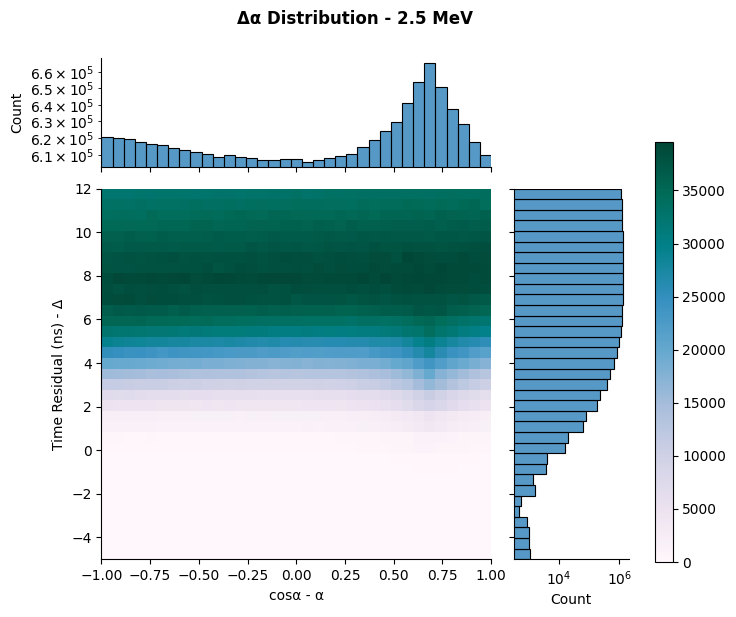

In [121]:
#[0:1000]
bins = 35
sn.reset_orig()
g = sn.jointplot(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins], 
             xlim = [-1,1], ylim = [inf_cut, up_cut], stat='count',
             cmap = cm.PuBuGn, hue_norm = (0,1), kind = 'hist', ratio = 3, #height = 2,
             marginal_kws = dict(bins = bins, log = True),
             marginal_ticks = True)

g.set_axis_labels('cosα - α', 'Time Residual (ns) - Δ')
plt.suptitle('Δα Distribution - 2.5 MeV', fontsize = 12, fontweight='bold')
plt.subplots_adjust(top=0.9)

#extract max count to plot in colorbar
counts, _, _ = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins,bins])

# Obtener la figura subyacente: crear cbar()
fig = g.fig
cbar_ax = fig.add_axes([1, 0.06, 0.03, 0.70])  # [left, bottom, width, height]
norm = plt.Normalize(vmin = 0, vmax = max(counts.ravel()))
sm = plt.cm.ScalarMappable(cmap = cm.PuBuGn, norm=norm)
cbar = fig.colorbar(sm, cax = cbar_ax)
#plt.savefig('figs/Δα Distribution - 2.5 MeV.png', format = 'png', bbox_inches = 'tight')
plt.show()

# 4 - Normalization by Nhits in cos(α) slices

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
C:\Users\joanc\AppData\Local\Temp\ipykernel_23324\1858531842.py:16: SyntaxWarning: invalid escape sequence '\m'
  N_title = 'Normalizarion by NHits - $\mathcal{L}(Δ,α)$ - 2.5 MeV'


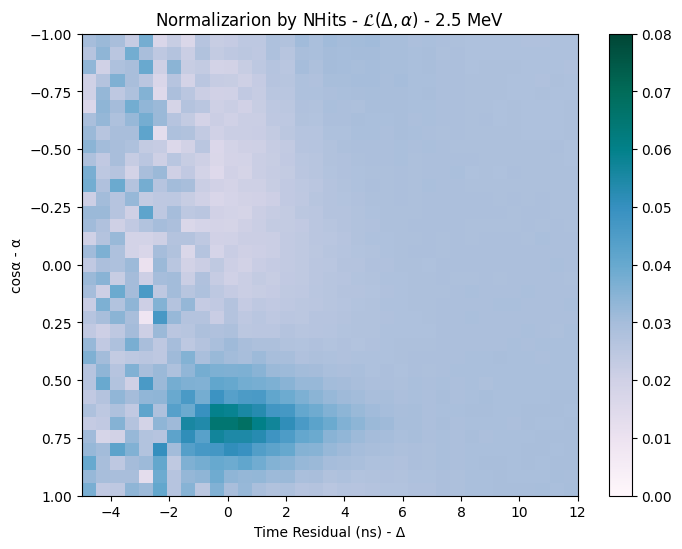

In [156]:
#Transforma Data into an Image Matrix
H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins])


#Normalization process
sum_hit = np.sum(H,axis=0)
H_normalized1 = H / sum_hit

#Now recover the data axis representation of time residual vs cos(alpha)
left = np.min(multi_time_residual_cut)
right = np.max(multi_time_residual_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

#titles
N_title = 'Normalizarion by NHits - $\mathcal{L}(Δ,α)$ - 2.5 MeV'
N_ylabel = 'cosα - α'
N_xlabel = 'Time Residual (ns) - Δ'

plt.figure(figsize=(8,6))
plt.imshow(H_normalized1, extent = [left, right, top, bottom], aspect="auto", cmap = cm.PuBuGn, vmin = 0, vmax = 0.08) #---> Here is our image as a Matrix Pixel
plt.title(N_title, fontsize= 12, fontstyle = 'normal')#, fontweight='bold')
plt.ylabel(N_ylabel)
plt.xlabel(N_xlabel)
plt.xlim(inf_cut, up_cut)
plt.ylim(1,-1)
plt.colorbar()
plt.savefig('figs/Norm Δα Distribution - 2.5 MeV.png', format = 'png', bbox_inches = 'tight')
plt.show()